## Wczytanie bibliotek i danych

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from gensim.utils import simple_preprocess
from collections import Counter
import gc

import texthero as hero

import spacy
from spacy.lang.pl.stop_words import STOP_WORDS

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'SelectableGroups dict interface')

In [4]:
# !python -m spacy download pl_core_news_lg
# Model wytrenowany dla języka polskiego https://spacy.io/models/pl ,
# alternatywnie można załadować np. 'pl_spacy_model'
nlp = spacy.load('pl_core_news_lg') 

In [6]:
# Wczytanie zbioru
df = pd.read_excel('inputs/budzety_obywatelskie.xlsx', sheet_name='Arkusz1')

In [7]:
df.shape

(23699, 4)

In [8]:
# Pozyskanie słów podstawowych z arkusza 'słowa podstawowe'
feats = pd.read_excel('inputs/budzety_obywatelskie.xlsx',sheet_name='słowa podstawowe', header=None)
feats = set(feats[0])

In [9]:
len(feats)

52

In [10]:
# Pozyskanie pełnych słów kluczowych (wraz z różnymi odmianami morfologicznymi)
# z arkusza 'filtrowanie'
feats_full = pd.read_excel('inputs/budzety_obywatelskie.xlsx',sheet_name='filtrowane').columns.tolist()
if 'rok ' in feats_full:
    feats_full.remove('rok ')
    feats_full.remove('miasto ')
    feats_full.remove('nazwa')
    feats_full.remove('WSZYSTKO')

In [11]:
len(feats_full)

281

In [12]:
gc.collect()

23951

## Preprocessing danych

In [13]:
# Usunięcie spacji po nazwach niektórych kolumn
df.rename(columns={'rok ': 'rok', 'miasto ':'miasto'}, inplace=True)

In [14]:
df

,rok,miasto,nazwa,WSZYSTKO
0,2020,GDYNIA,Projektistatus,0
1,2020,GDYNIA,Doposażenie parku pomiędzy Estakadą Kwiatkowsk...,3
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy O...,0
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",3
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy...,0
...,...,...,...,...
23694,NaN,NaN,NaN,0
23695,NaN,NaN,NaN,0
23696,NaN,NaN,NaN,0
23697,NaN,NaN,NaN,0


In [15]:
# Usunięcie wartości pustych
df = df[~df['nazwa'].isna()]

In [16]:
df

,rok,miasto,nazwa,WSZYSTKO
0,2020,GDYNIA,Projektistatus,0
1,2020,GDYNIA,Doposażenie parku pomiędzy Estakadą Kwiatkowsk...,3
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy O...,0
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",3
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy...,0
...,...,...,...,...
23688,2020,Kraków,Znani Biatopradniczanie dla Mieszkanców,0
23689,2020,Kraków,Zróbmy PARK PRZY LOKIETKA,1
23690,2020,Kraków,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultu...,1
23691,2020,Kraków,Zróbmy sobie Park,1


In [17]:
# Występują zdublowane nazwy miast np. SUWAŁKI i Suwałki
s1 = sorted([elem.upper() for elem in df['miasto'].unique()])
s2 = sorted(list(set([elem.upper() for elem in df['miasto'].unique()])))
print(s1 == s2)

False


In [18]:
# Wszystkie miasta piszemy wielką literą dla ujednolicenia
df['miasto'] = df['miasto'].map(lambda x: x.upper())

In [19]:
df.shape

(23687, 4)

In [20]:
# Usunięcie pustych wpisów

# Indeksy do usunięcia
rem_index = df[df['nazwa'].isnull()].index.tolist()
rem_index += df[df['nazwa']=='bd'].index.tolist()

df.drop(df.index[rem_index], inplace=True)

In [21]:
df.shape

(23670, 4)

In [22]:
# Usunięcie duplikatów
df = df.drop_duplicates()

In [23]:
df.shape

(23030, 4)

In [24]:
df['rok'].unique()

array([2020, 2019, 2018, '2018/19'], dtype=object)

In [28]:
df['rok'].value_counts(normalize=True)

2020       0.349066
2019       0.347851
2018       0.250716
2018/19    0.052366
Name: rok, dtype: float64

In [29]:
df['rok'] = df['rok'].apply(str)

In [34]:
df['nazwa'].dtype

dtype('O')

In [35]:
# Konwertujemy dodatkowo na string pomimo tego, że df['nazwa'].dtypes zwraca
# dtype('O'). (Występują ukryte liczby). Jakbyśmy tego nie zrobili to przy 
# simple_preprocess zwróciłoby błąd:
# decoding to str: need a bytes-like object, int found
df['nazwa'] = df['nazwa'].apply(str)

In [30]:
df

,rok,miasto,nazwa,WSZYSTKO
0,2020,GDYNIA,Projektistatus,0
1,2020,GDYNIA,Doposażenie parku pomiędzy Estakadą Kwiatkowsk...,3
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy O...,0
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",3
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy...,0
...,...,...,...,...
23687,2020,KRAKÓW,Zielony skwer na Zabtociu,1
23688,2020,KRAKÓW,Znani Biatopradniczanie dla Mieszkanców,0
23690,2020,KRAKÓW,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultu...,1
23691,2020,KRAKÓW,Zróbmy sobie Park,1


## Wstępny preprocessing

In [31]:
# Wyświetlanie szerszych kolumn, aby nie skracać wyświetlanych nazw tematów
pd.set_option('max_colwidth', 400)

In [36]:
# simple_preprocess z gensima usuwa liczby, interpunkcję, spowadza wszystko
# to małych liter i tworzy z wyrazów listę
df['tokens'] = df['nazwa'].apply(simple_preprocess)

In [37]:
df

,rok,miasto,nazwa,WSZYSTKO,tokens
0,2020,GDYNIA,Projektistatus,0,[projektistatus]
1,2020,GDYNIA,"Doposażenie parku pomiędzy Estakadą Kwiatkowskiego a wieżowcami przy ul. Dantyszka 2,4,8 w siłownię zewnętrzną i elementy małej architektury - pergole, bujane ławki itp.",3,"[doposażenie, parku, pomiędzy, estakadą, kwiatkowskiego, wieżowcami, przy, ul, dantyszka, siłownię, zewnętrzną, elementy, małej, architektury, pergole, bujane, ławki, itp]"
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy Obłuże rozwijające pamięć i koncentrację,0,"[cykliczne, warsztaty, dla, seniorów, dzielnicy, obłuże, rozwijające, pamięć, koncentrację]"
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",3,"[ogród, sąsiedzki, przy, dzikim, sadzie, ul, źródlana]"
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy ul. Niskiej na odcinku pomiędzy ul. Bohaterów Getta Warszawskiego i Hodowlaną,0,"[montaż, słupów, oświetleniowych, na, chodniku, przy, ul, niskiej, na, odcinku, pomiędzy, ul, bohaterów, getta, warszawskiego, hodowlaną]"
...,...,...,...,...,...
23687,2020,KRAKÓW,Zielony skwer na Zabtociu,1,"[zielony, skwer, na, zabtociu]"
23688,2020,KRAKÓW,Znani Biatopradniczanie dla Mieszkanców,0,"[znani, dla, mieszkanców]"
23690,2020,KRAKÓW,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultura w zieleni,1,"[zróbmy, skwer, przy, fabrycznej, edukacja, kultura, zieleni]"
23691,2020,KRAKÓW,Zróbmy sobie Park,1,"[zróbmy, sobie, park]"


In [38]:
# Prosty tokenizer, który zwraca lemmę słowa w oparciu o polski korpus spacy'ego.
# Tokenizacja może zająć 2-3 minuty
def my_tokenizer(tokens: str) -> list:
    return [token.lemma_ for token in nlp(tokens)]

df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x)).apply(my_tokenizer)

In [39]:
# Podgląd jakie są najpopularniejsze słowa
cnt = Counter()
df['tokens'].map(cnt.update)
cnt.most_common()

[('na', 6265),
 ('ul', 5022),
 ('dla', 4754),
 ('przy', 4102),
 ('do', 2363),
 ('plac', 2003),
 ('zabawa', 1907),
 ('park', 1731),
 ('nr', 1703),
 ('budowa', 1694),
 ('ulica', 1576),
 ('chodnik', 1535),
 ('remonta', 1322),
 ('dziecko', 1314),
 ('oraz', 1063),
 ('teren', 1044),
 ('osiedle', 964),
 ('szkoła', 912),
 ('zielony', 906),
 ('nowy', 883),
 ('zakup', 861),
 ('miejsce', 830),
 ('boisko', 828),
 ('miejski', 790),
 ('od', 787),
 ('modernizacja', 779),
 ('bezpieczny', 762),
 ('rowerowy', 739),
 ('biblioteka', 697),
 ('sp', 621),
 ('nawierzchnia', 613),
 ('sportowy', 595),
 ('pieszy', 588),
 ('mieszkaniec', 586),
 ('dzielnica', 578),
 ('podstawowy', 560),
 ('droga', 524),
 ('on', 519),
 ('wraz', 492),
 ('parking', 486),
 ('skwer', 485),
 ('rewitalizacja', 479),
 ('oświetlenie', 460),
 ('etap', 456),
 ('zajęcie', 425),
 ('drzewo', 425),
 ('wzdłuż', 423),
 ('wymiana', 409),
 ('przedszkole', 408),
 ('ogród', 403),
 ('siłownia', 400),
 ('senior', 395),
 ('warsztat', 394),
 ('rekreacyjny

In [40]:
# Utworzenie listy wszystkich słów według popularności
most_common_words = [token[0] for token in cnt.most_common()]
len(most_common_words)

17233

In [41]:
# Usunięcie z listy wszyskich  STOP_WORDsów
most_common_words = [word for word in most_common_words if word not in STOP_WORDS]
len(most_common_words)

17053

In [49]:
# Pomocnicza funkcja, która będzie zwracać tokeny tylko o określonej długości
def ret_tokens_with_len(number: int) -> list:
    return [token for token in most_common_words if len(token)==number]

# Rozpakowana lista tokenów o długości 2
tokens_with_len_two = ret_tokens_with_len(2)
print(*tokens_with_len_two)
print('Number of tokens with len 2:', len(tokens_with_len_two))

ul nr sp ii al pm św zł lo ks pl cz bm st in sw np pw dz ps sa bd zs oś il tj pn mb dk km jp m² dr bp ak pp wz wg mp le it os ew ów pg kw ch pt cm kd bł ab zt sz xx nt si vr sm wc pd up as zl śl ro vs zk cd da rz ww bb sq hr li zh mx tz qr mł dł om cc bl kl xc ue fu uw nz gd de dl ge db sb zf uś ai re mk ah ui cs el ob ya cn dw oi ws xl ca rc kr ut ba ne ct of uł sy dh gr ds pr is et nż gp dj dt
Number of tokens with len 2: 133


In [50]:
# Przegląd częstości występowania tokensów o długości 2
# Subiektywny osąd tokenów i uznanie ich za nieznaczących, małoistotnych
# lub za błędy w tokenizacji.
[(token,n) for token, n in cnt.most_common() if token in tokens_with_len_two]

[('ul', 5022),
 ('nr', 1703),
 ('sp', 621),
 ('ii', 284),
 ('al', 227),
 ('pm', 165),
 ('św', 86),
 ('zł', 70),
 ('lo', 68),
 ('ks', 67),
 ('pl', 45),
 ('cz', 37),
 ('bm', 36),
 ('st', 29),
 ('in', 23),
 ('sw', 23),
 ('np', 22),
 ('pw', 20),
 ('dz', 20),
 ('ps', 20),
 ('sa', 17),
 ('bd', 16),
 ('zs', 15),
 ('oś', 15),
 ('il', 12),
 ('tj', 11),
 ('pn', 10),
 ('mb', 10),
 ('dk', 10),
 ('km', 9),
 ('jp', 9),
 ('m²', 9),
 ('dr', 7),
 ('bp', 7),
 ('ak', 7),
 ('pp', 7),
 ('wz', 6),
 ('wg', 6),
 ('mp', 6),
 ('le', 6),
 ('it', 6),
 ('os', 6),
 ('ew', 6),
 ('ów', 6),
 ('pg', 6),
 ('kw', 5),
 ('ch', 5),
 ('pt', 5),
 ('cm', 5),
 ('kd', 5),
 ('bł', 5),
 ('ab', 4),
 ('zt', 4),
 ('sz', 4),
 ('xx', 4),
 ('nt', 4),
 ('si', 4),
 ('vr', 3),
 ('sm', 3),
 ('wc', 3),
 ('pd', 3),
 ('up', 3),
 ('as', 3),
 ('zl', 3),
 ('śl', 3),
 ('ro', 3),
 ('vs', 3),
 ('zk', 3),
 ('cd', 3),
 ('da', 3),
 ('rz', 3),
 ('ww', 2),
 ('bb', 2),
 ('sq', 2),
 ('hr', 2),
 ('li', 2),
 ('zh', 2),
 ('mx', 2),
 ('tz', 2),
 ('qr', 2),
 ('

In [51]:
# Zostawiamy wstępnie te tokeny
exclude_from_2 = ['ul', 'sp', 'zł', 'pl', 'oś', 'm²', 'al', 'lo', 'pm', 'pp']

# ul - ulica
# sp - szkoła podstawowa
# zł - informacja o potencjalnym koszcie inwestycji
# pl - plac
# oś - inwestycja posiada oświetlenie - uwaga, wyszukiwać ze spacją ' oś'
# m² - powierzchnia
# al - aleja
# lo - Liceum Ogólnoształcące
# pm - przedszkole miejskie
# pp - przedszkole publiczne (WIELKIMI LITERAMI)

In [52]:
# Pomocny przy subiektywnej ocenie tokenów może być podgląd rekordów za pomocą poniższej funkcji
df[df['nazwa'].str.contains('pl')]

,rok,miasto,nazwa,WSZYSTKO,tokens
10,2020,GDYNIA,"Festyny dzielnicowe i na Dzień Dziecka, kino i teatr plenerowy, wycieczki, ogród sensoryczny, kontener i pracownie naukowe na terenie SP 31, liga piłkarska, kursy i warsztaty",1,"[festyn, dzielnicowy, na, dzienie, dziecko, kino, teatr, plenerowy, wycieczka, ogród, sensoryczny, kontener, pracownia, naukowy, na, teren, sp, liga, piłkarski, kurs, warsztat]"
14,2020,GDYNIA,Ławka z zadaszeniem do karmienia i przewijania dzieci w pobliżu placu zabaw przy Promenadzie,0,"[ławka, zadaszenie, do, karmienie, przewijania, dziecko, pobliżu, plac, zabawa, przy, promenada]"
27,2020,GDYNIA,Doposażenie placu zabaw w Gdyni przy ul. Źródło Marii 16 w huśtawkę bez oparć dla dzieci starszych,0,"[doposażenie, plac, zabawa, gdyni, przy, ul, źródło, marii, huśtawka, bez, oparcie, dla, dziecko, stary]"
39,2020,GDYNIA,Dwa spektakle teatralne w plenerze: dla dzieci i dorosłych,0,"[dwa, spektakl, teatralny, plener, dla, dziecko, dorosły]"
43,2020,GDYNIA,Teatrzyki i planszówki w bibliotece,0,"[teatrzyk, planszówki, biblioteka]"
...,...,...,...,...,...
23590,2020,KRAKÓW,Stare Podgórze dla najmfodszych - plac zabaw na nowo!,0,"[stary, podgóra, dla, najmfodszych, plac, zabawa, na, nowo]"
23622,2020,KRAKÓW,Tyrolka na placu zabaw - ogródek im. Babci Zosi,1,"[tyrolka, na, plac, zabawa, ogródka, on, babcia, zosi]"
23623,2020,KRAKÓW,Tyrolka na placu zabaw przy ul. Aleksandry,0,"[tyrolka, na, plac, zabawa, przy, ul, aleksandry]"
23634,2020,KRAKÓW,Wiecej kodów do platformy e-booków dla Zwierzyáca,0,"[wiecej, kod, do, platforma, booków, dla, zwierzyáca]"


In [53]:
# Zakładamy, że dwuliterowe tokeny (z kilkoma wyjątkami) to szum (błędy przy tokenizacji)
# Sprawdźmy czy jest ich dużo w naszym zbiorze (wyłączając listę z wyjątkami)

noise = [elem for elem in ret_tokens_with_len(2) if elem not in exclude_from_2]
[elem for elem in cnt.most_common() if elem[0] in noise]

[('nr', 1703),
 ('ii', 284),
 ('św', 86),
 ('ks', 67),
 ('cz', 37),
 ('bm', 36),
 ('st', 29),
 ('in', 23),
 ('sw', 23),
 ('np', 22),
 ('pw', 20),
 ('dz', 20),
 ('ps', 20),
 ('sa', 17),
 ('bd', 16),
 ('zs', 15),
 ('il', 12),
 ('tj', 11),
 ('pn', 10),
 ('mb', 10),
 ('dk', 10),
 ('km', 9),
 ('jp', 9),
 ('dr', 7),
 ('bp', 7),
 ('ak', 7),
 ('wz', 6),
 ('wg', 6),
 ('mp', 6),
 ('le', 6),
 ('it', 6),
 ('os', 6),
 ('ew', 6),
 ('ów', 6),
 ('pg', 6),
 ('kw', 5),
 ('ch', 5),
 ('pt', 5),
 ('cm', 5),
 ('kd', 5),
 ('bł', 5),
 ('ab', 4),
 ('zt', 4),
 ('sz', 4),
 ('xx', 4),
 ('nt', 4),
 ('si', 4),
 ('vr', 3),
 ('sm', 3),
 ('wc', 3),
 ('pd', 3),
 ('up', 3),
 ('as', 3),
 ('zl', 3),
 ('śl', 3),
 ('ro', 3),
 ('vs', 3),
 ('zk', 3),
 ('cd', 3),
 ('da', 3),
 ('rz', 3),
 ('ww', 2),
 ('bb', 2),
 ('sq', 2),
 ('hr', 2),
 ('li', 2),
 ('zh', 2),
 ('mx', 2),
 ('tz', 2),
 ('qr', 2),
 ('mł', 2),
 ('dł', 2),
 ('om', 2),
 ('cc', 2),
 ('bl', 2),
 ('kl', 2),
 ('xc', 2),
 ('ue', 2),
 ('fu', 2),
 ('uw', 2),
 ('nz', 1),
 ('g

In [54]:
# Dołączmy szum do stopwordsów
all_stop_words = set.union(STOP_WORDS, set([elem for elem in ret_tokens_with_len(2) if elem not in exclude_from_2]))
len(all_stop_words)

504

In [55]:
# Czyścimy nasze tokeny ze STOP_WORDsów
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token not in all_stop_words])

In [56]:
df

,rok,miasto,nazwa,WSZYSTKO,tokens
0,2020,GDYNIA,Projektistatus,0,[projektistatus]
1,2020,GDYNIA,"Doposażenie parku pomiędzy Estakadą Kwiatkowskiego a wieżowcami przy ul. Dantyszka 2,4,8 w siłownię zewnętrzną i elementy małej architektury - pergole, bujane ławki itp.",3,"[doposażenie, park, pomiędzy, estakada, kwiatkowskiego, wieżowiec, ul, dantyszka, siłownia, zewnętrzny, element, mały, architektura, pergola, bujać, ławka, itp]"
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy Obłuże rozwijające pamięć i koncentrację,0,"[cykliczny, warsztat, senior, dzielnica, obłuże, rozwijać, pamięć, koncentracja]"
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",3,"[ogród, sąsiedzki, dziki, sadź, ul, źródlana]"
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy ul. Niskiej na odcinku pomiędzy ul. Bohaterów Getta Warszawskiego i Hodowlaną,0,"[montaż, słup, oświetleniowy, chodnik, ul, niski, odcinek, pomiędzy, ul, bohater, getto, warszawski, hodowlany]"
...,...,...,...,...,...
23687,2020,KRAKÓW,Zielony skwer na Zabtociu,1,"[zielony, skwer, zabtociu]"
23688,2020,KRAKÓW,Znani Biatopradniczanie dla Mieszkanców,0,"[znany, mieszkanców]"
23690,2020,KRAKÓW,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultura w zieleni,1,"[zrobić, skwer, fabryczny, edukacja, kultura, zieleń]"
23691,2020,KRAKÓW,Zróbmy sobie Park,1,"[zrobić, park]"


In [57]:
# Podgląd jakie są najpopularniejsze słowa po usunięciu stopwordsów
cnt = Counter()
df['tokens'].map(cnt.update)
cnt.most_common()

[('ul', 5022),
 ('plac', 2003),
 ('zabawa', 1907),
 ('park', 1731),
 ('budowa', 1694),
 ('ulica', 1576),
 ('chodnik', 1535),
 ('remonta', 1322),
 ('dziecko', 1314),
 ('teren', 1044),
 ('osiedle', 964),
 ('szkoła', 912),
 ('zielony', 906),
 ('nowy', 883),
 ('zakup', 861),
 ('miejsce', 830),
 ('boisko', 828),
 ('miejski', 790),
 ('modernizacja', 779),
 ('bezpieczny', 762),
 ('rowerowy', 739),
 ('biblioteka', 697),
 ('sp', 621),
 ('nawierzchnia', 613),
 ('sportowy', 595),
 ('pieszy', 588),
 ('mieszkaniec', 586),
 ('dzielnica', 578),
 ('podstawowy', 560),
 ('droga', 524),
 ('wraz', 492),
 ('parking', 486),
 ('skwer', 485),
 ('rewitalizacja', 479),
 ('oświetlenie', 460),
 ('etap', 456),
 ('zajęcie', 425),
 ('drzewo', 425),
 ('wzdłuż', 423),
 ('wymiana', 409),
 ('przedszkole', 408),
 ('ogród', 403),
 ('siłownia', 400),
 ('senior', 395),
 ('warsztat', 394),
 ('rekreacyjny', 388),
 ('budynek', 377),
 ('zieleń', 375),
 ('gra', 367),
 ('wykonanie', 362),
 ('strefa', 355),
 ('przejście', 346),
 (

In [58]:
# Funkcja zwracająca DataFrame z wartościami Prawda/Fałsz, gdzie kolumnami
# są słowa z 'feats'
def has_feats(tokens: list) -> pd.DataFrame:
    def ret_tokens(tokens):
        return [(token in tokens) for token in feats]
    
    df_result = tokens.map(ret_tokens).apply(pd.Series)
    df_result.columns = feats 
    return df_result

x = has_feats(df['tokens'])
x

,zbiornik,sadzić,estetyczny,lęgowy,ekologia,rekultywacja,trawnik,nasadzić,bylina,łąka,...,trawniki,antysmogowy,estetyka,kwietnik,deszczowy,kwitnąć,ogrodowy,pielęgnacja,smog,zieleniec
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23688,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23690,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23691,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
x.nunique()

zbiornik        2
sadzić          2
estetyczny      2
lęgowy          2
ekologia        2
rekultywacja    2
trawnik         2
nasadzić        2
bylina          2
łąka            2
park            2
ogrodniczy      2
ogród           2
ozdobny         2
roślina         2
kwietny         2
ekologiczny     2
zazielenić      2
parkowy         2
leśny           2
natura          2
las             2
kwiatowy        2
roslin          2
zasadzić        2
gaj             2
kwiat           2
krzew           2
drzewo          2
trawiasty       2
ptasi           2
sztuczny        2
zielony         2
przyroda        2
przyrodniczy    2
żywopłot        2
dębowy          2
kasztanowiec    2
leś             1
powietrze       2
dziki           2
naturalny       2
trawniki        1
antysmogowy     2
estetyka        2
kwietnik        2
deszczowy       2
kwitnąć         2
ogrodowy        2
pielęgnacja     2
smog            2
zieleniec       2
dtype: int64

In [60]:
df_all = pd.concat([df,x], axis=1)

del x
gc.collect()

# Łączymy przetworzone tokeny w stringi
df_all['names'] = df_all['tokens'].map(lambda x: ' '.join(x))

In [61]:
df_all

,rok,miasto,nazwa,WSZYSTKO,tokens,zbiornik,sadzić,estetyczny,lęgowy,ekologia,...,antysmogowy,estetyka,kwietnik,deszczowy,kwitnąć,ogrodowy,pielęgnacja,smog,zieleniec,names
0,2020,GDYNIA,Projektistatus,0,[projektistatus],False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,projektistatus
1,2020,GDYNIA,"Doposażenie parku pomiędzy Estakadą Kwiatkowskiego a wieżowcami przy ul. Dantyszka 2,4,8 w siłownię zewnętrzną i elementy małej architektury - pergole, bujane ławki itp.",3,"[doposażenie, park, pomiędzy, estakada, kwiatkowskiego, wieżowiec, ul, dantyszka, siłownia, zewnętrzny, element, mały, architektura, pergola, bujać, ławka, itp]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,doposażenie park pomiędzy estakada kwiatkowskiego wieżowiec ul dantyszka siłownia zewnętrzny element mały architektura pergola bujać ławka itp
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy Obłuże rozwijające pamięć i koncentrację,0,"[cykliczny, warsztat, senior, dzielnica, obłuże, rozwijać, pamięć, koncentracja]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,cykliczny warsztat senior dzielnica obłuże rozwijać pamięć koncentracja
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",3,"[ogród, sąsiedzki, dziki, sadź, ul, źródlana]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,ogród sąsiedzki dziki sadź ul źródlana
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy ul. Niskiej na odcinku pomiędzy ul. Bohaterów Getta Warszawskiego i Hodowlaną,0,"[montaż, słup, oświetleniowy, chodnik, ul, niski, odcinek, pomiędzy, ul, bohater, getto, warszawski, hodowlany]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,montaż słup oświetleniowy chodnik ul niski odcinek pomiędzy ul bohater getto warszawski hodowlany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,2020,KRAKÓW,Zielony skwer na Zabtociu,1,"[zielony, skwer, zabtociu]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,zielony skwer zabtociu
23688,2020,KRAKÓW,Znani Biatopradniczanie dla Mieszkanców,0,"[znany, mieszkanców]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,znany mieszkanców
23690,2020,KRAKÓW,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultura w zieleni,1,"[zrobić, skwer, fabryczny, edukacja, kultura, zieleń]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,zrobić skwer fabryczny edukacja kultura zieleń
23691,2020,KRAKÓW,Zróbmy sobie Park,1,"[zrobić, park]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,zrobić park


In [62]:
# Funkcja sprawdzająca, czy w opisie występuje szkoła lub przedszkole
def has_school(text: str) -> bool:
    match = re.compile(r'(?:szkol|szkoł|SP|Podstaw|\sLO\s|\sPM\s|\sPP)')
    res = len(match.findall(text)) >0
    return res

df_all['szkola'] = df_all['nazwa'].map(has_school)

In [63]:
# Funkcja sprawdzająca, czy w opisie występuje ulica lub aleja
def has_street(text: str) -> bool:
    match = re.compile(r'(?:\sul\.|\sal\.)')
    res = len(match.findall(text)) >0
    return res

df_all['ulica'] = df_all['nazwa'].map(has_street)

In [64]:
# Funkcja sprawdzająca, czy w opisie występuje oświetlenie
def has_light(text: str) -> bool:
    match = re.compile(r'oświet')
    res = len(match.findall(text)) >0
    return res

df_all['oswietlenie'] = df_all['nazwa'].map(has_light)

In [65]:
df_all.to_hdf('outputs/budzety_clean.hd5', key='df_all')

In [66]:
df_all

,rok,miasto,nazwa,WSZYSTKO,tokens,zbiornik,sadzić,estetyczny,lęgowy,ekologia,...,deszczowy,kwitnąć,ogrodowy,pielęgnacja,smog,zieleniec,names,szkola,ulica,oswietlenie
0,2020,GDYNIA,Projektistatus,0,[projektistatus],False,False,False,False,False,...,False,False,False,False,False,False,projektistatus,False,False,False
1,2020,GDYNIA,"Doposażenie parku pomiędzy Estakadą Kwiatkowskiego a wieżowcami przy ul. Dantyszka 2,4,8 w siłownię zewnętrzną i elementy małej architektury - pergole, bujane ławki itp.",3,"[doposażenie, park, pomiędzy, estakada, kwiatkowskiego, wieżowiec, ul, dantyszka, siłownia, zewnętrzny, element, mały, architektura, pergola, bujać, ławka, itp]",False,False,False,False,False,...,False,False,False,False,False,False,doposażenie park pomiędzy estakada kwiatkowskiego wieżowiec ul dantyszka siłownia zewnętrzny element mały architektura pergola bujać ławka itp,False,True,False
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy Obłuże rozwijające pamięć i koncentrację,0,"[cykliczny, warsztat, senior, dzielnica, obłuże, rozwijać, pamięć, koncentracja]",False,False,False,False,False,...,False,False,False,False,False,False,cykliczny warsztat senior dzielnica obłuże rozwijać pamięć koncentracja,False,False,False
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",3,"[ogród, sąsiedzki, dziki, sadź, ul, źródlana]",False,False,False,False,False,...,False,False,False,False,False,False,ogród sąsiedzki dziki sadź ul źródlana,False,True,False
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy ul. Niskiej na odcinku pomiędzy ul. Bohaterów Getta Warszawskiego i Hodowlaną,0,"[montaż, słup, oświetleniowy, chodnik, ul, niski, odcinek, pomiędzy, ul, bohater, getto, warszawski, hodowlany]",False,False,False,False,False,...,False,False,False,False,False,False,montaż słup oświetleniowy chodnik ul niski odcinek pomiędzy ul bohater getto warszawski hodowlany,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,2020,KRAKÓW,Zielony skwer na Zabtociu,1,"[zielony, skwer, zabtociu]",False,False,False,False,False,...,False,False,False,False,False,False,zielony skwer zabtociu,False,False,False
23688,2020,KRAKÓW,Znani Biatopradniczanie dla Mieszkanców,0,"[znany, mieszkanców]",False,False,False,False,False,...,False,False,False,False,False,False,znany mieszkanców,False,False,False
23690,2020,KRAKÓW,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultura w zieleni,1,"[zrobić, skwer, fabryczny, edukacja, kultura, zieleń]",False,False,False,False,False,...,False,False,False,False,False,False,zrobić skwer fabryczny edukacja kultura zieleń,False,False,False
23691,2020,KRAKÓW,Zróbmy sobie Park,1,"[zrobić, park]",False,False,False,False,False,...,False,False,False,False,False,False,zrobić park,False,False,False


In [67]:
# Najważniejsze kolumny m.in. z pierwotnym tekstem, przetworzonym tekstem i tokenami
df_all[['rok', 'miasto', 'WSZYSTKO', 'szkola', 'nazwa','tokens', 'names']]

,rok,miasto,WSZYSTKO,szkola,nazwa,tokens,names
0,2020,GDYNIA,0,False,Projektistatus,[projektistatus],projektistatus
1,2020,GDYNIA,3,False,"Doposażenie parku pomiędzy Estakadą Kwiatkowskiego a wieżowcami przy ul. Dantyszka 2,4,8 w siłownię zewnętrzną i elementy małej architektury - pergole, bujane ławki itp.","[doposażenie, park, pomiędzy, estakada, kwiatkowskiego, wieżowiec, ul, dantyszka, siłownia, zewnętrzny, element, mały, architektura, pergola, bujać, ławka, itp]",doposażenie park pomiędzy estakada kwiatkowskiego wieżowiec ul dantyszka siłownia zewnętrzny element mały architektura pergola bujać ławka itp
2,2020,GDYNIA,0,False,Cykliczne warsztaty dla seniorów z dzielnicy Obłuże rozwijające pamięć i koncentrację,"[cykliczny, warsztat, senior, dzielnica, obłuże, rozwijać, pamięć, koncentracja]",cykliczny warsztat senior dzielnica obłuże rozwijać pamięć koncentracja
3,2020,GDYNIA,3,False,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana","[ogród, sąsiedzki, dziki, sadź, ul, źródlana]",ogród sąsiedzki dziki sadź ul źródlana
4,2020,GDYNIA,0,False,Montaż słupów oświetleniowych na chodniku przy ul. Niskiej na odcinku pomiędzy ul. Bohaterów Getta Warszawskiego i Hodowlaną,"[montaż, słup, oświetleniowy, chodnik, ul, niski, odcinek, pomiędzy, ul, bohater, getto, warszawski, hodowlany]",montaż słup oświetleniowy chodnik ul niski odcinek pomiędzy ul bohater getto warszawski hodowlany
...,...,...,...,...,...,...,...
23687,2020,KRAKÓW,1,False,Zielony skwer na Zabtociu,"[zielony, skwer, zabtociu]",zielony skwer zabtociu
23688,2020,KRAKÓW,0,False,Znani Biatopradniczanie dla Mieszkanców,"[znany, mieszkanców]",znany mieszkanców
23690,2020,KRAKÓW,1,False,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultura w zieleni,"[zrobić, skwer, fabryczny, edukacja, kultura, zieleń]",zrobić skwer fabryczny edukacja kultura zieleń
23691,2020,KRAKÓW,1,False,Zróbmy sobie Park,"[zrobić, park]",zrobić park


## Chmura słów

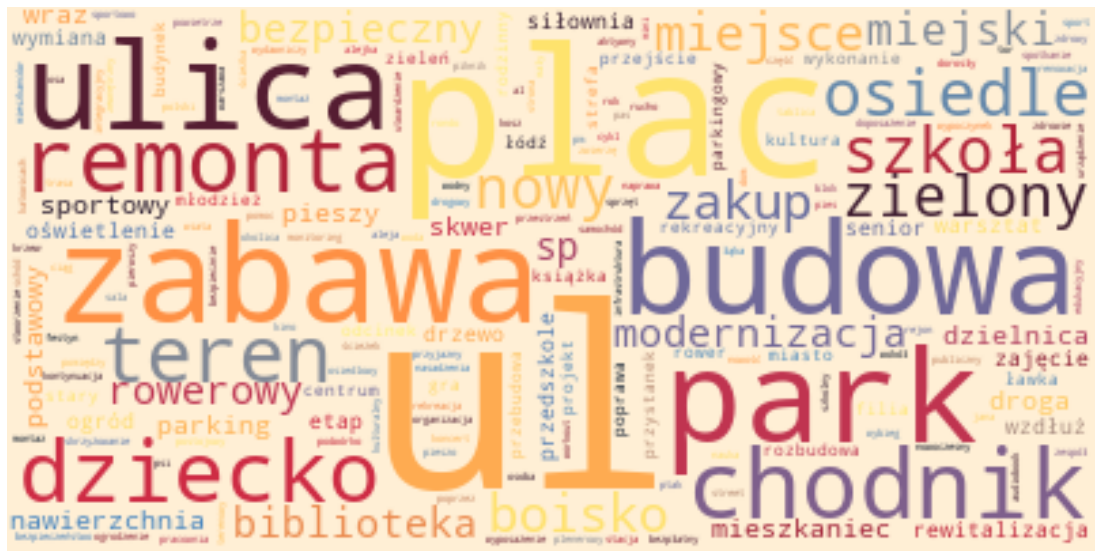

In [68]:
hero.visualization.wordcloud(df_all['names'])